## Visualizing single cell examples for pooled data
- Inputs are:
  - REQUIRED:
    -  **Input_gene_or_guide** - (str), it can be a string of gene symbol or guide (20 chars)
        - e.g., 'KRT28' or 'GTTGAAGAGCTAGATCAACG'
    -  **batch_name** - (str) batch name
        - e.g., '20200805_A549_WG_Screen' 
    - **rootDir** - image, metadata and overlays address is following the structure of dirs in the s3 bucket so we need to fix the root directory and everything else is being formed accroding to the s3 bucket structure 
        - e.g., '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
  - OPTIONAL:
    -  **n_cells** - (int), number of single cells to be visualized, it is ignored if cell_selection_method is geometric_median
    -  **box_size** - (int), size of box in pixels for cropping a cell    
    -  **channels** - (list), list of channels you want to plot
        - e.g., ['DNA','Mito','Phalloidin','WGA','ER','Outline'] 
    -  **cell_selection_method** - (str) can be one of the following methods
        - random - generate n randomly selected cells
        - representative - clusters the data and sample from the "closest to mean cluster"
        - geometric_median - plots single sample than is the geometric median of samples
        
        
###  Run time:

- For random cells (n_cells=6) -> ~ 3-4 mins
- For representative cells (For )  -> ~ 3-4 mins
- For geometric median (for calculate the gm from 1500 random subset of total cells) -> ~ 3 mins
  

In [3]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing
import matplotlib.pyplot as plt
from singlecell.read import read_single_cell_sql
from singlecell.process import extract_single_cell_samples
from singlecell.visualize import visualize_n_SingleCell
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
import pooled_cell_painting_single_cell_visualization
import time
import gc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cd ..

/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis


## Visualize single cells for the input gene of guide

In [2]:
%%time

input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

# ########################## set directories
## CP186
# batch='20200805_A549_WG_Screen';

## CP257
batch='20210422_6W_CP257';


########################## set directories
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                       '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/\
single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

#################### options for parameters to set
n_cells=6
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='geometric_median'

channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

##################### read metadata and create the file name for input guide or gene
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
gene=input_matched_rows.gene_symbol.unique().tolist()[0]
guides_ls=input_matched_rows.sgRNA.unique().tolist()

all_guides_gms_ls=[]
# gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

for gi in gene_guids_ls:
    df_p_s=pd.read_csv(gi);

    for ch in channels:
        df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
        df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

    df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
    +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

    df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
    df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

    df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

    if df_p_s.shape[0]>0:
        df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                        replace = False).reset_index(drop=True),n_cells,cell_selection_method);
        all_guides_gms_ls.append(df_samples)

df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
    df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)
    
else:
    df_samples=df_p_s_all.copy()

################  visualize cells

f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

KeyboardInterrupt: 

In [ ]:
# df_samples
# f=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);

In [ ]:
np.__version__

In [ ]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);
# df_samples
# df_p_s

In [ ]:
df_p_s[df_p_s.columns[df_p_s.columns.str.contains('Alig')]]

In [ ]:
def pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir,\
            n_cells=6,box_size=100,channels=['DNA','Mito','Phalloidin','WGA','ER','Outline'],\
                                                   cell_selection_method='random'):
    

    ########################## set directories
#     batch='20200805_A549_WG_Screen';
#     rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
    sc_files_dir=rootDir+'workspace/software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/single_cell_by_guide/'

    im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257

    ##################### read metadata and create the file name for input guide or gene
    metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
    metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

    input_matched_rows = metadata_orig[(metadata_orig['gene_symbol']==input_gene_or_guide) | (metadata_orig['sgRNA']==input_gene_or_guide)]
    gene=input_matched_rows.gene_symbol.unique().tolist()[0]
    guides_ls=input_matched_rows.sgRNA.unique().tolist()

    all_guides_gms_ls=[]
    # gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    gene_guids_ls=[sc_files_dir+batch+'_single_cell_normalized_ALLBATCHES__'+gi+'_'+gene+'.csv.gz' for gi in guides_ls]

    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);

        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s.sample(n = np.min([1500,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    df_p_s_all=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)    

    if len(gene_guids_ls)>1 and df_p_s_all.shape[0]>n_cells:
        df_samples=df_p_s_all.sample(n = np.min([n_cells,df_p_s_all.shape[0]]),replace = False).reset_index(drop=True)

    else:
        df_samples=df_p_s_all.copy()

    ################  visualize cells

    return visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene_or_guide+'_'+cell_selection_method);


input_gene_or_guide='KRT28'
# input_gene_or_guide='GTTGAAGAGCTAGATCAACG'

batch='20200805_A549_WG_Screen';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'


pooled_cell_painting_single_cell_visualization(input_gene_or_guide,batch,rootDir);

In [ ]:
# metadaDataFiles
# metadata_orig
# df_p_s.columns
# df_p_s[df_p_s.eq(5500).any(1)]

In [ ]:
# os.listdir("/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/")

In [ ]:
# python restore_intelligent.py imaging-platform "projects/2015_10_05_DrugRepurposing_AravindSubramanian_GolubLab_Broad/workspace/backend/2016_04_01_a549_48hr_batch1/SQ00015195/"

### Read single cell data per guide takes ~1 mins

In [ ]:
%%time
file_name='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/\
software/CP186-A549-WG/data/1.profiles/20200805_A549_WG_Screen/single_cell/\
single_cell_by_guide/20200805_A549_WG_Screen_single_cell_normalized_ALLBATCHES__GTTGAAGAGCTAGATCAACG_KRT28.csv.gz'
df_p_s0=pd.read_csv(file_name);
df_p_s0.head()

In [ ]:
# df_p_s0[df_p_s0.columns[df_p_s0.columns.str.contains('utline')]]
# df_p_s0.columns[df_p_s0.columns.str.contains('uid')]

In [ ]:
# df_p_s0['Cells_AreaShape_Center_X'].describe()

In [ ]:
# visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=cell_selection_method);

### Unarchive needed data

In [9]:
# def unarchive_file(f2unarchive,bucket_name,user_profile):
#     """
#     unarchive input file

#     Inputs:
#     bucket_name: eg, pooled-cell-painting, imaging-plateform
#     user_profile: profile name that is used for accessing the above bucket (check in sudo vim ~/.aws/credentials)
#     proj_path: path to the project eg,2018_11_20_Periscope_Calico/workspace/analysis/

#     output:
#     command to run
#     """

#     cmd='aws s3api  restore-object  --profile '+user_profile+\
#             ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/'+f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
#     return cmd
import os
user_profile='calico'
bucket_name='pooled-cell-painting'
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
# for p in plates:
#     for w in wells:
#         for s in sites:
# batch='20200805_A549_WG_Screen';

batch='20210422_6W_CP257'
plate_well_dirs_ls=os.listdir(rootDir+'/workspace/analysis/'+batch)
for di in plate_well_dirs_ls:
    f2unarchive='workspace/analysis/'+batch+'/'+di+'/CorrDNA_Site_'+di.split('-')[-1]+'_Overlay.png'
    if os.path.exists(rootDir+f2unarchive):
        cmd='aws s3api  restore-object  --profile '+user_profile+\
        ' --bucket '+bucket_name+'  --key projects/2018_11_20_Periscope_Calico/'+\
        f2unarchive+'   --restore-request GlacierJobParameters={"Tier"="Standard"}'
        print(cmd)
        os.system(cmd)

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257B-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257D-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257F-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257H-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257J-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257K-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257L-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well1-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well2-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well4-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-29/CorrDNA_Site_29_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well5-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-14/CorrDNA_Site_14_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-15/CorrDNA_Site_15_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-16/CorrDNA_Site_16_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-17/CorrDNA_Site_17_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-25/CorrDNA_Site_25_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-26/CorrDNA_Site_26_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-27/CorrDNA_Site_27_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-28/CorrDNA_Site_28_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-33/CorrDNA_Site_33_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-34/CorrDNA_Site_34_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-35/CorrDNA_Site_35_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-36/CorrDNA_Site_36_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-37/CorrDNA_Site_37_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-38/CorrDNA_Site_38_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-39/CorrDNA_Site_39_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-4/CorrDNA_Site_4_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-46/CorrDNA_Site_46_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-47/CorrDNA_Site_47_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-48/CorrDNA_Site_48_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-51/CorrDNA_Site_51_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-55/CorrDNA_Site_55_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-56/CorrDNA_Site_56_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-57/CorrDNA_Site_57_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-58/CorrDNA_Site_58_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-59/CorrDNA_Site_59_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-64/CorrDNA_Site_64_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-65/CorrDNA_Site_65_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-66/CorrDNA_Site_66_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-67/CorrDNA_Site_67_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-68/CorrDNA_Site_68_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-69/CorrDNA_Site_69_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-7/CorrDNA_Site_7_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-75/CorrDNA_Site_75_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-76/CorrDNA_Site_76_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-77/CorrDNA_Site_77_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-78/CorrDNA_Site_78_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-79/CorrDNA_Site_79_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-85/CorrDNA_Site_85_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-86/CorrDNA_Site_86_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-87/CorrDNA_Site_87_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-88/CorrDNA_Site_88_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-89/CorrDNA_Site_89_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-93/CorrDNA_Site_93_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-94/CorrDNA_Site_94_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}



An error occurred (InvalidObjectState) when calling the RestoreObject operation: Restore is not allowed for the object's current storage class


aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257N-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-12/CorrDNA_Site_12_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-13/CorrDNA_Site_13_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-14/CorrDNA_Site_14_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-43/CorrDNA_Site_43_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-44/CorrDNA_Site_44_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-45/CorrDNA_Site_45_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-46/CorrDNA_Site_46_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-73/CorrDNA_Site_73_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-74/CorrDNA_Site_74_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well1-75/CorrDNA_Site_75_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-22/CorrDNA_Site_22_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-23/CorrDNA_Site_23_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-24/CorrDNA_Site_24_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-25/CorrDNA_Site_25_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-52/CorrDNA_Site_52_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-53/CorrDNA_Site_53_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-54/CorrDNA_Site_54_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-55/CorrDNA_Site_55_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-83/CorrDNA_Site_83_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-84/CorrDNA_Site_84_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well2-85/CorrDNA_Site_85_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-32/CorrDNA_Site_32_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-33/CorrDNA_Site_33_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-61/CorrDNA_Site_61_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-63/CorrDNA_Site_63_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-64/CorrDNA_Site_64_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well3-98/CorrDNA_Site_98_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-12/CorrDNA_Site_12_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-40/CorrDNA_Site_40_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-41/CorrDNA_Site_41_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-42/CorrDNA_Site_42_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-43/CorrDNA_Site_43_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-70/CorrDNA_Site_70_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-71/CorrDNA_Site_71_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-72/CorrDNA_Site_72_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well4-73/CorrDNA_Site_73_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-18/CorrDNA_Site_18_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-19/CorrDNA_Site_19_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-21/CorrDNA_Site_21_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-22/CorrDNA_Site_22_Overlay.png   --restore-request G

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-49/CorrDNA_Site_49_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-5/CorrDNA_Site_5_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-50/CorrDNA_Site_50_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-51/CorrDNA_Site_51_Overlay.png   --restore-request Gla

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-8/CorrDNA_Site_8_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-80/CorrDNA_Site_80_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-82/CorrDNA_Site_82_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well5-83/CorrDNA_Site_83_Overlay.png   --restore-request Gla

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-3/CorrDNA_Site_3_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-30/CorrDNA_Site_30_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-31/CorrDNA_Site_31_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-32/CorrDNA_Site_32_Overlay.png   --restore-request Gla

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-6/CorrDNA_Site_6_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-60/CorrDNA_Site_60_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-62/CorrDNA_Site_62_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-63/CorrDNA_Site_63_Overlay.png   --restore-request Gla

aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-95/CorrDNA_Site_95_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-96/CorrDNA_Site_96_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-97/CorrDNA_Site_97_Overlay.png   --restore-request GlacierJobParameters={"Tier"="Standard"}
aws s3api  restore-object  --profile calico --bucket pooled-cell-painting  --key projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257O-Well6-98/CorrDNA_Site_98_Overlay.png   --restore-request G

In [ ]:
# unarchive image folders
plate_well_ls=os.listdir('/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped')
# python restore_intelligent.py pooled-cell-painting "projects/2018_11_20_Periscope_Calico/20200805_A549_WG_Screen/images_corrected_cropped/"
channels=['DNA','Mito','Phalloidin','WGA','ER']

for pli in plate_well_ls:
    for chi in channels:
        os.system('python ~/imaging-backup-scripts/restore_intelligent.py pooled-cell-painting "projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped/'+\
pli+'/Corr'+chi+'"')

In [ ]:
plate_well_dirs_ls[0].split('-')[-1]

In [ ]:
# plate_well_ls

## Plot geometric median of all guides of an input gene

In [48]:
%%capture
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=10
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='geometric_median'
channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

genes_ls=metadata_orig.gene_symbol.unique().tolist()

for igi in range(12257,len(genes_ls)):
    input_gene=genes_ls[igi]
    all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s,_=edgeCellFilter(df_p_s,image_width=im_size,edge_margin=box_size/2);

        if df_p_s.shape[0]>0:
            df_samples,cp_features_analysis = extract_single_cell_samples.extract_single_cell_samples(df_p_s.sample(n = np.min([1000,df_p_s.shape[0]]),\
                            replace = False).reset_index(drop=True),n_cells,cell_selection_method);
            all_guides_gms_ls.append(df_samples)

    all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)
    
    if all_guides_gms_df.shape[0]==1:
        all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    
    
    fig=visualize_n_SingleCell.visualize_n_SingleCell_pooled(channels,all_guides_gms_df,box_size,im_size,title=input_gene+'_'+cell_selection_method);
    
#     sgsfs
    
    resultsDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
    fig.savefig(resultsDir+input_gene+'.png')  
    plt.ioff()
    del fig

OSError: [Errno 5] Input/output error

In [8]:
all_guides_gms_df.loc[0,'Path_Outlines']

'/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/analysis/20210422_6W_CP257/CP257A-Well4-50//CorrDNA_Site_50_Overlay.png'

In [47]:
igi

12256

In [13]:
igi

11526

In [6]:
igi

11308

In [ ]:
igi, 5323 error

In [5]:
# genes_ls.index('LOC653602')
# pd.concat([all_guides_gms_df]*2, ignore_index=True)
len(genes_ls)

20423

In [8]:
ls /home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/

ls: cannot access /home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/: Operation not permitted


In [12]:
igi,input_gene,all_guides_gms_df.shape,gene_guids_ls

(92,
 'C12orf75',
 (4, 3793),
 ['/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__AACTCCACCGCCACCAGCGC_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__CATCTTTGGCTGCTCCTGCA_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_ALLBATCHES__CCGTAACAGAAGATGACAAG_C12orf75.csv.gz',
  '/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/software/CP257-HeLa-WG/data/1.profiles/20210422_6W_CP257/single_cell/single_cell_by_guide/20210422_6W_CP257_single_cell_normalized_A

In [ ]:
os.system('mkdir -p /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level')

In [ ]:
ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations

In [ ]:
# metadata_orig.gene_symbol.unique().tolist()

In [ ]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=10
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='representative'
channels=['DNA','Mito','Phalloidin','WGA','ER','Outline']

resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/'+cell_selection_method+'_guide_level/'


# genes_ls=metadata_orig.gene_symbol.unique().tolist()

genes_ls=['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2',\
'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H','ALDOB', 'CCDC115', 'VMA21', 'TMEM199',\
'TM9SF4','ALG10','DPM1','DPM2','DPM3','ALG3','ALG9','ALG12','ALG6','ALG8','ALG10B','DDOST',\
'RPN1','RPN2','STT3A','DAD1','TUSC3', 'MOGS','GANAB','MAN1A1','MAN1A2','MAN1B1','MAN1C1','STT3B',\
'MAN2C1','ENGASE','FDPS','GGPS1','NEU2','NEU4','ALG5','DHDDS','DOLPP1','DOLK','DPAGT1',\
'ALG1','ALG2','ALG11','ALG13','ALG14','ACTR2','ACTR3','ARPC2','ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251',"TOMM20","nontargeting"]


genes_ls=['ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251']

# genes_ls=['ALG12','TUSC3','FDPS','ALG5','DPAGT1','ALG1']

# # genes_ls=['TMEM251']

# Meraj_only_g_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']

# genes_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']
# genes_ls=['TOMM20']
# genes_ls=["nontargeting"]

for igi in range(len(genes_ls)):
    input_gene=genes_ls[igi]
#     all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls[78:]:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
        
        #.sample(n = np.min([1500,df_p_s.shape[0]]),\
        if df_p_s.shape[0]>0:
            
            df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);
            
            resdir=resultsDir+input_gene#+'/'+gi.split('_')[-2]
            os.system("mkdir -p "+resdir)

    #             all_guides_gms_ls.append(df_samples)

    #         all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)

    #         if all_guides_gms_df.shape[0]==1:
    #             all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    

            df_samples['label']=df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)
            fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
            gc.collect()
            
        #     resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
            fig.savefig(resdir+'/'+gi.split('_')[-2]+'.png',dpi=500)  
            plt.ioff()

In [3]:
# ARPC2
# OverflowError: cannot convert float infinity to integer
# df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);
# len(gene_guids_ls),igi
gene_guids_ls.index(gi)

145

In [7]:
df_p_s.shape

(28, 3825)

In [5]:
# df_p_s=df_p_s.interpolate()
df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);

In [ ]:
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').
'ALG12','TUSC3','FDPS','ALG5','DPAGT1','ALG1'

In [ ]:
OverflowError: cannot convert float infinity to integer
'ARPC3'

In [13]:
igi,input_gene

(3, 'ARPC3')

In [21]:
# fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);

imm=skimage.io.imread("/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/20210422_6W_CP257/images_corrected_cropped/CP257L_Well3/CorrDNA/CorrDNA_Site_38.tiff")

print(imm.min(),imm.max())

207 40891


In [42]:
# plt.figure()
# plt.hist(imm,bins=1000)

image = np.array([25,28, 51, 102, 153,190, 200], dtype=np.uint8)
exposure.rescale_intensity(image,in_range=(28,190))
# array([  0, 127, 255], dtype=uint8)

array([  0,   0,  36, 116, 196, 255, 255], dtype=uint8)

In [24]:
# igi,input_gene
# df_p_s.shape
# df_p_s

from skimage import exposure
high_contrast = exposure.rescale_intensity(imm, in_range=(imm.min(), imm.max()))

In [ ]:
plt.figure()
plt.hist(imm,bins=1000)

In [25]:
high_contrast.min(),high_contrast.max()

(0, 65535)

In [32]:
# skdemo.imshow_with_histogram
# import skdemo

# skdemo.imshow_with_histogram(image);

In [23]:
igi,input_gene

(52, 'ALG1')

In [14]:
df_p_s[cp_features_analysis].values

array([[-0.7355  ,  1.0528  ,  0.026408, ..., -0.020025,  1.8017  ,
         0.074201],
       [-0.94241 ,  0.22344 , -1.4951  , ..., -0.020025, -0.59233 ,
        -0.3717  ],
       [-0.3348  ,  0.27862 , -1.6223  , ..., -0.020025,  0.1492  ,
        -0.065269],
       ...,
       [-0.54578 , -0.1878  , -2.4494  , ..., -0.019657,  0.75583 ,
        -0.54779 ],
       [-0.4284  , -0.12338 , -2.4541  , ..., -0.019657, -1.6632  ,
        -0.48986 ],
       [-0.29261 , -3.14    , -0.92651 , ..., -0.019657, -0.018799,
         0.18728 ]])

In [25]:
igi

56

In [4]:
genes_ls=['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2',\
'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H','ALDOB', 'CCDC115', 'VMA21', 'TMEM199',\
'TM9SF4','ALG10','DPM1','DPM2','DPM3','ALG3','ALG9','ALG12','ALG6','ALG8','ALG10B','DDOST',\
'RPN1','RPN2','STT3A','DAD1','TUSC3', 'MOGS','GANAB','MAN1A1','MAN1A2','MAN1B1','MAN1C1','STT3B',\
'MAN2C1','ENGASE','FDPS','GGPS1','NEU2','NEU4','ALG5','DHDDS','DOLPP1','DOLK','DPAGT1',\
          'ALG1','ALG2','ALG11','ALG13','ALG14']

In [3]:
Meraj_g_ls=["ATP6V0D1","ATP6V1F","ATP6AP1","ATP6V1C1","ATP6V1H","ATP6V1G1","ATP6V1D"
"ALG1L","ALG3","ALG9","ALG12","DPM1","DPM2","ARPC2","ARPC3","ARPC4","ACTR2","ACTR3"]

In [5]:
set(genes_ls) & set(Meraj_g_ls)

{'ALG12',
 'ALG3',
 'ALG9',
 'ATP6V1C1',
 'ATP6V1F',
 'ATP6V1G1',
 'ATP6V1H',
 'DPM1',
 'DPM2'}

## Visualize channel specific representative cells

- Clustering based on channel specific features for selecting single cells

<IPython.core.display.Javascript object>


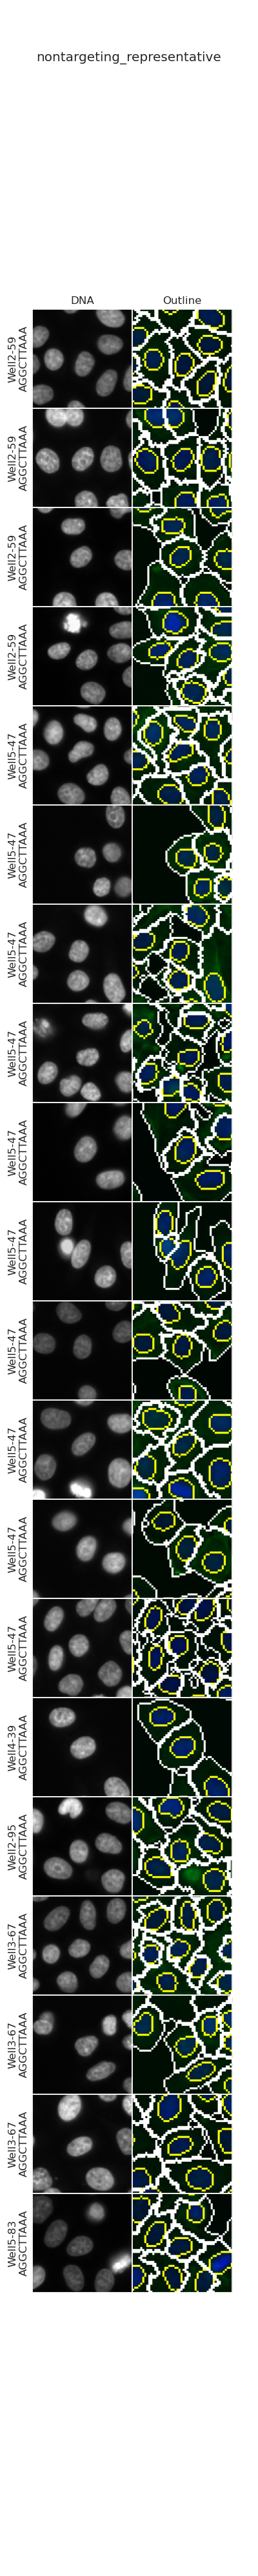

nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:334: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative
nontargeting_representative


 /home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/utils/visualize_data.py:396: UserWarning:Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


nontargeting_representative
nontargeting_representative


MemoryError: Unable to allocate 231. MiB for an array with shape (5500, 5500) and data type float64

In [6]:
import glob
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'

# batch='20200805_A549_WG_Screen';
batch='20210422_6W_CP257';


batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 # hardcoded for now, TODO: create a dictionary if this number is different for 257 vs 186

### metadata 
metadata_dir=rootDir+'workspace/metadata/'+batch+'/'
metadata_orig= pd.read_csv(metadata_dir+'Barcodes.csv')

# input_gene='KRT28'
n_cells=20
box_size=100

# how we select cells which can be 'random','representative','geometric_median'
cell_selection_method='representative'
channels=['DNA','Mito','Phalloidin','WGA','ER']

resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/'+\
cell_selection_method+'_guide_level_channel_level/'

genes_ls=['ATP6V1A', 'ATP6V1B1', 'ATP6V1B2', 'ATP6V1C1', 'ATP6V1C2', 'ATP6V1D', 'ATP6V1E1', 'ATP6V1E2',\
'ATP6V1G1', 'ATP6V1G2', 'ATP6V1G3', 'ATP6V1F', 'ATP6V1H','ALDOB', 'CCDC115', 'VMA21', 'TMEM199',\
'TM9SF4','ALG10','DPM1','DPM2','DPM3','ALG3','ALG9','ALG12','ALG6','ALG8','ALG10B','DDOST',\
'RPN1','RPN2','STT3A','DAD1','TUSC3', 'MOGS','GANAB','MAN1A1','MAN1A2','MAN1B1','MAN1C1','STT3B',\
'MAN2C1','ENGASE','FDPS','GGPS1','NEU2','NEU4','ALG5','DHDDS','DOLPP1','DOLK','DPAGT1',\
'ALG1','ALG2','ALG11','ALG13','ALG14','ACTR2','ACTR3','ARPC2','ARPC3','ATP6AP1',\
'ATP6V0D1','ATP6V1DALG1L','TMEM251',"TOMM20","nontargeting"]

# genes_ls=metadata_orig.gene_symbol.unique().tolist()

genes_ls=["nontargeting"]

# Meraj_only_g_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']

# genes_ls=['ACTR2','ACTR3','ARPC2','ARPC3','ARPC4','ATP6AP1','ATP6V0D1','ATP6V1DALG1L']
# genes_ls=['TOMM20']
# genes_ls=["nontargeting"]

for igi in range(len(genes_ls)):
    input_gene=genes_ls[igi]
    all_guides_gms_ls=[]
    gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
    for gi in gene_guids_ls[77:]:
        df_p_s=pd.read_csv(gi);
        
        for ch in channels:
            df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
            df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

        df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
        +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

        df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
        df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];
        
        df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);
        
        #.sample(n = np.min([1500,df_p_s.shape[0]]),\
#         channel_name_in_feats=['DAPI_Painting','ConA','Mito','Phalloidin','WGA']
        align_column_ch_name_map={'DNA':'DAPI_Painting','ER':'ConA','Mito':'Mito','Phalloidin':'Phalloidin','WGA':'WGA'}
        
        if df_p_s.shape[0]>0:
            for ch in channels:
                channel_feats=df_p_s.columns[df_p_s.columns.str.contains('_'+align_column_ch_name_map[ch]+'|_X|_Y|FileName_|Path|Metadata_')]
                df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s[channel_feats],n_cells,cell_selection_method);

                resdir=resultsDir+input_gene+'/'+gi.split('_')[-2]
                os.system("mkdir -p "+resdir)

        #             all_guides_gms_ls.append(df_samples)

        #         all_guides_gms_df=pd.concat(all_guides_gms_ls,ignore_index=True).drop_duplicates(ignore_index=True)

        #         if all_guides_gms_df.shape[0]==1:
        #             all_guides_gms_df=pd.concat([all_guides_gms_df]*2, ignore_index=True)    

                df_samples['label']=df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)
#                 fig=visualize_n_SingleCell_pooled(channels,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
                channels2=[ch,'Outline']
                fig=visualize_n_SingleCell_pooled(channels2,df_samples,box_size,im_size,title=input_gene+'_'+cell_selection_method);
                gc.collect()
            #     resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/geometric_median_guide_level/'
                fig.savefig(resdir+'/'+ch+'.png',dpi=500)  
                plt.ioff()

In [7]:
# df_samples.shape
# np.power(2,16)
# channels
gene_guids_ls.index(gi)

77

In [16]:
df_samples.columns[df_samples.columns.str.contains('FileName')]

Index(['FileName_CorrDNA', 'FileName_CorrMito', 'FileName_CorrPhalloidin',
       'FileName_CorrWGA', 'FileName_CorrER', 'FileName_CorrOutline'],
      dtype='object')

In [19]:
df_p_s.columns.str.contains('_ConA')

array([False, False, False, ..., False, False, False])

In [5]:
# ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/representative_guide_level_channel_level/

In [26]:
2500*454

1135000

### For each guide save one cell from each plate well site 
- There are 454 non-targeting guids and 9 plates and 6 wells and ~100 sites
- For each guide select 1 randomly selected cell from each plate well site -> "Metadata_site"  metadata column 
  - Which is about 2500 cells per guide -> this got to memory error
  
- Instead i sample 10 cells from each plat well -> results are saved in 
https://imaging-platform.s3.us-east-1.amazonaws.com/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/nontargeting_dfs

- Total shape would be about

In [6]:
import glob
import pandas as pd
batch='20210422_6W_CP257';
rootDir='/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/'
batch_multi_name_dict={'20210422_6W_CP257':'CP257-HeLa-WG',\
                   '20200805_A549_WG_Screen':'CP186-A549-WG'}
batchName2=batch_multi_name_dict[batch]
sc_files_dir=rootDir+'workspace/software/'+batchName2+'/data/1.profiles/'+batch+'/single_cell/single_cell_by_guide/'
im_size=5500 

# resultsDir='/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/'+batch+'/'+\
# cell_selection_method+'_guide_level_channel_level/'


input_gene="nontargeting"
all_guides_gms_ls=[]
gene_guids_ls=glob.glob(sc_files_dir+'*_'+input_gene+'.csv.gz')
nontarget_df_ls=[]
ix=0
for gi in gene_guids_ls:
    df_p_s=pd.read_csv(gi);
    ix+=1
    print(ix)
#     afdsdf
#     nontarget_df_ls.append(df_p_s.groupby('Metadata_site').sample(n = 1, replace = False).reset_index(drop=True)) # this gives memory error
    nontarget_df_ls.append(df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_well']).sample(n = 10, replace = True).reset_index(drop=True)) # this gives memory error    
#     for ch in channels:
#         df_p_s["PathName_Corr"+ch]=rootDir+batch+'/images_corrected_cropped/'+df_p_s["Metadata_Foci_plate"]+'_'+df_p_s["Metadata_Foci_well"]+'/Corr'+ch
#         df_p_s["FileName_Corr"+ch]="Corr"+ch+"_"+"Site_"+df_p_s["Metadata_Foci_site_location"].astype(str)+".tiff"

#     df_p_s["Path_Outlines"]=rootDir+'workspace/analysis/'+batch+'/'+df_p_s["Metadata_Foci_plate"]+'-'+df_p_s["Metadata_Foci_well"]+'-'+df_p_s["Metadata_Foci_site_location"].astype(str)+'/'\
#     +'/CorrDNA_Site_'+df_p_s["Metadata_Foci_site_location"].astype(str)+'_Overlay.png'

#     df_p_s["Nuclei_Location_Center_X"]=df_p_s["Cells_AreaShape_Center_X"];
#     df_p_s["Nuclei_Location_Center_Y"]=df_p_s["Cells_AreaShape_Center_Y"];

#     df_p_s=edgeCellFilter2(df_p_s,im_size,box_size/2);

#     #.sample(n = np.min([1500,df_p_s.shape[0]]),\
#     if df_p_s.shape[0]>0:

#         df_samples,cp_features_analysis = extract_single_cell_samples(df_p_s,n_cells,cell_selection_method);
            
#         nontarget_df_ls.append(df_samples)
pd.concat(nontarget_df_ls,axis=0,ignore_index=True).to_csv('/home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico//workspace/visualizations/'+batch+'/nontargeting_dfs/guide_ten_per_plate_well.csv',index=False)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [25]:
for gi in gene_guids_ls[251:]:
    df_p_s=pd.read_csv(gi);
    ix+=1
    print(ix)
#     afdsdf
#     nontarget_df_ls.append(df_p_s.groupby('Metadata_site').sample(n = 1, replace = False).reset_index(drop=True)) # this gives memory error
    nontarget_df_ls.append(df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_well']).sample(n = 10, replace = True).reset_index(drop=True)) # this gives memory error    


252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454


In [9]:
df_p_s=pd.read_csv(gene_guids_ls[2]);
df_p_s.groupby('Metadata_site').sample(n = 1, replace = False).reset_index(drop=True).shape  


(1800, 3810)

In [27]:
# 540*545
https://imaging-platform.s3.us-east-1.amazonaws.com/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/nontargeting_dfs

294300

In [ ]:
rootDir+'/workspace/visualizations/'+batch+'/nontargeting_dfs/'
git rm --cached <filename>

In [35]:
pd.concat(nontarget_df_ls,axis=0,ignore_index=True).to_csv('/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico//workspace/visualizations/'+batch+'/nontargeting_dfs/guide_ten_per_plate_well.csv',index=False)


OSError: [Errno 107] Transport endpoint is not connected: '/home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/nontargeting_dfs'

In [4]:
ls /home/ubuntu/calbucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/20210422_6W_CP257/nontargeting_dfs

In [6]:
# df_p_s.groupby('Metadata_site').sample(n = 1, replace = False).reset_index(drop=True).shape
l

(1161, 3810)

In [36]:
ls /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/

ls: cannot access /home/ubuntu/bucket/projects/2018_11_20_Periscope_Calico/workspace/visualizations/: Transport endpoint is not connected


In [22]:
df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_well']).sample(n = 10, replace = False).reset_index(drop=True)

Metadata_Foci_Parent_Cells  Metadata_Foci_Cell_Quality_Index  \
0                          9861                                 1   
1                          3207                                 1   
2                          6999                                 1   
3                          9434                                 2   
4                          4056                                 1   
..                          ...                               ...   
535                        1370                                 1   
536                       11473                                 1   
537                        5383                                 1   
538                        1373                                 1   
539                        1162                                 1   

    Metadata_Foci_Barcode_MatchedTo_GeneCode  \
0                               nontargeting   
1                               nontargeting   
2                               nontargeting   
3                               nontargeting   
4                               nontargeting   
..                                       ...   
535                             nontargeting   
536                             nontargeting   
537                             nontargeting   
538                             nontargeting   
539                             nontargeting   

    Metadata_Foci_Barcode_MatchedTo_Barcode  \
0                      AAAATTATCGGAAACGGTAG   
1                      AAAATTATCGGAAACGGTAG   
2                      AAAATTATCGGAAACGGTAG   
3                      AAAATTATCGGAAACGGTAG   
4                      AAAATTATCGGAAACGGTAG   
..                                      ...   
535                    AAAATTATCGGAAACGGTAG   
536                    AAAATTATCGGAAACGGTAG   
537                    AAAATTATCGGAAACGGTAG   
538                    AAAATTATCGGAAACGGTAG   
539                    AAAATTATCGGAAACGGTAG   

     Metadata_Foci_Barcode_MatchedTo_Score_mean  \
0                                       1.00000   
1                                       1.00000   
2                                       1.00000   
3                                       0.91667   
4                                       1.00000   
..                                          ...   
535                                     1.00000   
536                                     1.00000   
537                                     1.00000   
538                                     1.00000   
539                                     1.00000   

     Metadata_Foci_Barcode_MatchedTo_Score_count  \
0                                              1   
1                                              3   
2                                              2   
3                                              3   
4                                              2   
..                                           ...   
535                                            4   
536                                            1   
537                                            2   
538                                            5   
539                                            1   

    Metadata_Foci_cell_quality_method  Metadata_Foci_ImageNumber  \
0                              simple                        289   
1                              simple                        187   
2                              simple                         37   
3                              simple                        451   
4                              simple                        571   
..                                ...                        ...   
535                            simple                        120   
536                            simple                        408   
537                            simple                         66   
538                            simple                        492   
539                            simple           

In [18]:
df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_well']).size()

Metadata_Foci_plate  Metadata_Foci_well
CP257A               Well1                 5
                     Well2                 5
                     Well3                 5
                     Well4                 5
                     Well5                 5
                     Well6                 5
CP257B               Well1                 5
                     Well2                 5
                     Well3                 5
                     Well4                 5
                     Well5                 5
                     Well6                 5
CP257D               Well1                 5
                     Well2                 5
                     Well3                 5
                     Well4                 5
                     Well5                 5
                     Well6                 5
CP257F               Well1                 5
                     Well2                 5
                     Well3                 5
               

In [25]:
# df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_site']).size()
df_p_s.groupby(['Metadata_Foci_plate','Metadata_Foci_well','Metadata_site']).size()#.groupby(['Metadata_Foci_plate'])

Metadata_Foci_plate  Metadata_Foci_well  Metadata_site  
CP257A               Well1               CP257A-Well1-13    1
                                         CP257A-Well1-14    5
                                         CP257A-Well1-15    2
                                         CP257A-Well1-16    2
                                         CP257A-Well1-17    2
                                                           ..
CP257N               Well6               CP257N-Well6-83    3
                                         CP257N-Well6-84    1
                                         CP257N-Well6-85    2
                                         CP257N-Well6-88    1
                                         CP257N-Well6-95    3
Length: 2490, dtype: int64

In [16]:
df_p_s.columns[df_p_s.columns.str.contains('site')]

Index(['Metadata_Foci_site', 'Metadata_Foci_site_location', 'Metadata_site'], dtype='object')

In [7]:
jump_orf_meta_tsv="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/metadata/JUMP-ORF/ORF_list.tsv"
annot=pd.read_csv(jump_orf_meta_tsv,sep='\t')
batches=annot['Batch'].unique()
# feature_list=['Cytoplasm_AreaShape_Zernike_9_3',\
#  'Cells_RadialDistribution_RadialCV_Mito_1of4',\
#  'Cytoplasm_Granularity_3_RNA']
# feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',\
# 'Nuclei_Texture_Contrast_mito_8_0',\
# 'Cells_Texture_SumEntropy_mito_8_45',\
# 'Nuclei_Texture_DifferenceVariance_mito_8_0']

# feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16']
annot.head()

Symbol       plate_map_name               Batch Assay_Plate_Barcode  \
0   A1BG  OAC18.OAB81.82.83.A  2021_08_09_Batch11          BR00126545   
1   A1BG  OAC18.OAB81.82.83.A  2021_08_09_Batch11          BR00126547   
2   A1BG  OAC18.OAB81.82.83.A  2021_08_09_Batch11          BR00126546   
3   A1BG  OAC18.OAB81.82.83.A  2021_08_09_Batch11          BR00126548   
4   A1BG  OAC18.OAB81.82.83.A  2021_08_09_Batch11          BR00126549   

  well_position        broad_sample pert_type control_type  
0           C15  ccsbBroad304_10667       trt          NaN  
1           C15  ccsbBroad304_10667       trt          NaN  
2           C15  ccsbBroad304_10667       trt          NaN  
3           C15  ccsbBroad304_10667       trt          NaN  
4           C15  ccsbBroad304_10667       trt          NaN

In [10]:
# plates=annot.loc[annot['Batch']==b,'Assay_Plate_Barcode'].unique()
annot.groupby(['Batch','Assay_Plate_Barcode']).size()

Batch               Assay_Plate_Barcode
2021_04_26_Batch1   BR00117035             384
                    BR00117036             384
                    BR00117037             384
                    BR00117038             384
                    BR00117039             384
                                          ... 
2021_08_30_Batch13  BR00124781             384
                    BR00124782             384
                    BR00126062             384
                    BR00126404             384
                    BR00126543             384
Length: 237, dtype: int64

In [8]:
# files = glob.glob(path + "/**/*.txt", recursive = True)

In [12]:
24*6*2

288

In [2]:
int(237/13)

18